In [41]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn.linear_model as skl_lm
from sklearn.lda import LDA
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'svg',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

### Load dataset

In [2]:
# Using R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Data/Default.xlsx')
df['default2'] = df.default.map({'No':0, 'Yes':1})
df['student2'] = df.student.map({'No':0, 'Yes':1})
df.head(3)

  default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

###  Figure 4.1

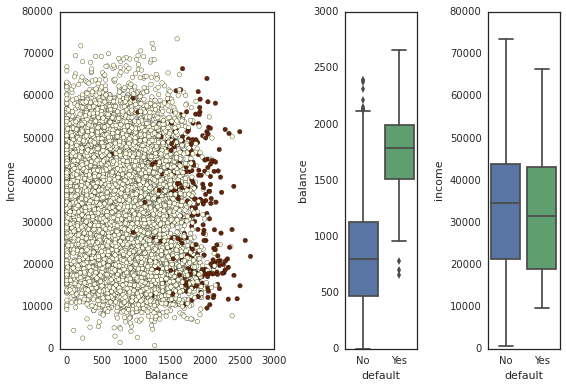

In [3]:
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

ax1.scatter(df.balance, df.income, c=df.default2, cmap=mpl.cm.YlOrBr)
ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3)
gs.tight_layout(plt.gcf())

## Logistic Regression
### Figure 4.2

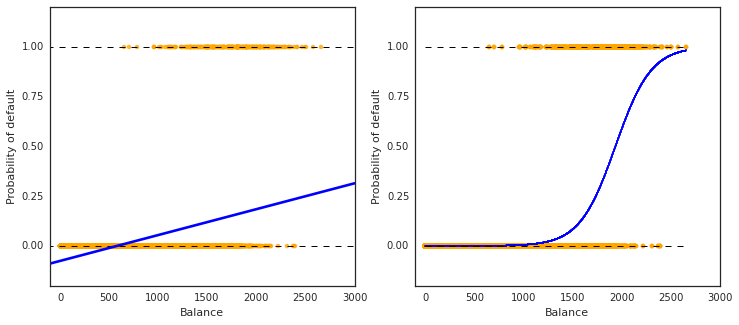

In [36]:
X_train = df.balance.reshape(df.balance.size,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)

# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.regplot(df.balance, df.default2, order=1, ci=None, scatter_kws={'color':'orange'}, line_kws={'color':'b'}, ax=ax1)

ax2.scatter(X_train, y, color='orange')
ax2.scatter(X_test, pd.DataFrame(prob)[1], color='b', s=1)

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0], xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0], xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

### Table 4.1

In [66]:
X_train = df.balance.reshape(df.balance.size,1) 
y = df.default2

#####  scikit-learn

In [68]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0)
classes:  [0 1]
coefficients:  [[ 0.00549892]]
intercept : [-10.65132921]


##### statsmodels

In [69]:
X_train_ = sm.add_constant(X_train)
est = smf.Logit(y, X_train_).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               default2   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Jun 2015   Pseudo R-squ.:                  0.4534
Time:                        12:40:40   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                6.233e-290
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -10.6513      0.361    -29.491      0.000       -11.359    -9.943
x1             0.0055      0.000     24.952      0.000         0.005     0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

###  Table 4.2

In [81]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               default2   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Jun 2015   Pseudo R-squ.:                0.004097
Time:                        12:57:53   Log-Likelihood:                -1454.3
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                 0.0005416
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.5041      0.071    -49.554      0.000        -3.643    -3.366
student2       0.4049      0.115      3.520      0.000         0.179     0.630
==============================================================================
"""

###  Table 4.3 - Multiple Logistic Regression

In [77]:
X_train_ = sm.add_constant(X_train)
est = smf.Logit(y, X_train_).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               default2   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Jun 2015   Pseudo R-squ.:                  0.4619
Time:                        12:51:36   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -10.8690      0.492    -22.079      0.000       -11.834    -9.904
x1             0.0057      0.000     24.737      0.000         0.005     0.006
x2          3.033e-06    8.2e-06      0.370      0.712      -1.3e-05  1.91e-05
x3            -0.6468      0.236     -2.738      0.006        -1.110    -0.184
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Figure 4.3 - Confounding

In [ ]:
X_train = df[df.student == 'Yes'].balance.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

X_train2 = df[df.student == 'No'].balance.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [42]:
df.groupby(['student','default']).size().unstack()

default    No  Yes
student           
No       6850  206
Yes      2817  127

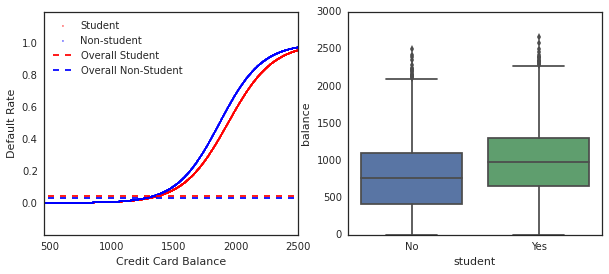

In [63]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(X_test, pd.DataFrame(prob)[1], color='r', s=1, label='Student')
ax1.scatter(X_test, pd.DataFrame(prob2)[1], color='b', s=1, label='Non-student')
ax1.hlines(127/2817, colors='r', label='Overall Student', xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='b', label='Overall Non-Student',xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')

ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2)

## Linear Discriminant Analysis
###Table 4.4 


In [38]:
X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LDA(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack()

True default status         No  Yes
Predicted default status           
No                        9645  254
Yes                         22   79

In [45]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

             precision    recall  f1-score   support

         No       0.97      1.00      0.99      9667
        Yes       0.78      0.24      0.36       333

avg / total       0.97      0.97      0.97     10000



### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [47]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack()

True default status         No  Yes
Predicted default status           
No                        9435  140
Yes                        232  193